# Util functions

In [1]:
import numpy as np

def create_results_dict(
        input
    ):
    """ Returns results as a dictionary, to make it easier to compare between runs. """

    nt, dt, time_array, T_parcel_array, P_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array, \
    qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts, \
    spectra_arr, con_ts, act_ts, evp_ts, dea_ts, acc_ts, aut_ts, precip_ts, particles_array, \
    rc_liq_avg_array, rc_liq_std_array, TAU_ts_array, albedo_array = input

    results = {
        'nt': nt, 'dt': dt, 'time': time_array, 'T_parcel': T_parcel_array, 'P_parcel': P_parcel_array, 'RH_parcel': RH_parcel_array, 'q_parcel': q_parcel_array, 'z_parcel': z_parcel_array,
        'qa': qa_ts, 'qc': qc_ts, 'qr': qr_ts, 'na': na_ts, 'nc': nc_ts, 'nr': nr_ts,
        'spectra': spectra_arr, 'con': con_ts, 'act': act_ts, 'evp': evp_ts, 'dea': dea_ts, 'acc': acc_ts, 'aut': aut_ts, 'precip': precip_ts, 'particles': particles_array,
        'rc_liq_avg': rc_liq_avg_array, 'rc_liq_std': rc_liq_std_array, 'tau': TAU_ts_array, 'albedo': albedo_array
    }
    
    return results

def rwp(results, w):

    from PyLCM.parcel import parcel_rho

    rho_parcel_array, _, _ = parcel_rho(results['P_parcel'], results['T_parcel'])

    return np.cumsum(rho_parcel_array * results['qr'] * w * results['dt'])

# Setup model

In [2]:
# Import necessary modules
from PyLCM.animation import *
from PyLCM.widget import *
from PyLCM.timestep_routine import *
from PyLCM.parameters import *
# Import user modifiable modules
from Post_process.analysis import *
from Post_process.print_plot import *

# Uncomment lines below when changing source files
#######################
%load_ext autoreload
%autoreload 2
#######################

In [3]:
from IPython.display import clear_output

dt_widget, nt_widget, Condensation_widget, Collision_widget, switch_sedi_removal, n_particles_widget, max_z_widget = model_steering_input()
T_widget, P_widget, RH_widget, w_widget, z_widget = parcel_info_input()
ascending_mode_widget = ascending_mode_input()
entrainment_widget, stability_widget, entrainment_start_widget, entrainment_end_widget, entrainment_rate_widget  = entrainment_input()
kohler_widget = kohler_settings()
hygroscopicity_widget = kappa_settings()
mode_aero_init_widget = aero_mode_input()
gridwidget = grid_modes_input()
mode_displaytype_widget = timestep_display_mode_settings()


# You can override the widget values by entering the inputs in the code below
# This is more convenient as the widgets override your original input when reloaded

# Model steering parameters

dt_widget.value = 1 # s
nt_widget.value = 3500
Condensation_widget.value = True
Collision_widget.value = True
switch_sedi_removal.value = False
n_particles_widget.value = 200
max_z_widget.value = 1500 # m


# Parcel initial parameters

T_widget.value = 289.27 # K
P_widget.value = 101181 # Pa
RH_widget.value = 0.83
w_widget.value = 0.3 # m s-1
z_widget.value = 0 # m
ascending_mode_widget.value = 'linear' # linear / sine / in_cloud_oscillation


# Entrainment parameters

entrainment_widget.value = False
stability_widget.value = 'Stable' # Stable / Unstable / Neutral
entrainment_start_widget.value = 1000 # s
entrainment_end_widget.value = 1030 # s
entrainment_rate_widget.value = 0.05 # ?

qv_init = RH_widget.value * esatw( T_widget.value ) / ( P_widget.value - RH_widget.value * esatw( T_widget.value ) ) * r_a / rv
qv_profiles, theta_profiles, z_env = create_env_profiles(T_widget.value, qv_init, z_widget.value, P_widget.value, stability_widget.value)


# Koehler theory

kohler_widget.value = False
hygroscopicity_widget.value = False
mode_aero_init_widget.value = 'Random' # Random / Weighting_factor


# Initialisation parameters for aerosol (up to 4 modes)
# mu = mean droplet radius | sigma = std. of mu | kappa = hygroscopicity parameter

# Mode #1
gridwidget[1,0].value = 100 # N_aero (cm-3)
gridwidget[2,0].value = 0.04 # mu (um)
gridwidget[3,0].value = 2.0 # sigma (-)
gridwidget[4,0].value = 1.0 #1.6 # kappa

# Mode #2
gridwidget[1,1].value = 0 # N_aero (cm-3)
gridwidget[2,1].value = 0 # mu (um)
gridwidget[3,1].value = 0 # sigma (-)
gridwidget[4,1].value = 0 # kappa

# Mode #3
gridwidget[1,2].value = 0 # N_aero (cm-3)
gridwidget[2,2].value = 0 # mu (um)
gridwidget[3,2].value = 0 # sigma (-)
gridwidget[4,2].value = 0 # kappa

# Mode #4
gridwidget[1,3].value = 0 # N_aero (cm-3)
gridwidget[2,3].value = 0 # mu (um)
gridwidget[3,3].value = 0 # sigma (-)
gridwidget[4,3].value = 0 # kappa


# Display mode

mode_displaytype_widget.value = 'text_fast' # text_fast / graphics


# Comment this out the display the widgets
clear_output()

# Run model

In [4]:
test_run \
    = create_results_dict(timesteps_function(
        n_particles_widget, P_widget, \
        RH_widget, T_widget, w_widget, nt_widget, \
        dt_widget, rm_spec, ascending_mode_widget, \
        mode_displaytype_widget, z_widget, max_z_widget, \
        Condensation_widget, Collision_widget, \
        mode_aero_init_widget, gridwidget, kohler_widget.value, \
        hygroscopicity_widget.value, switch_sedi_removal.value, \
        entrainment_rate_widget.value,entrainment_widget.value,qv_profiles, theta_profiles, entrainment_start_widget.value, entrainment_end_widget.value
    ))

value: Time (s)  z (m)    T (K)    qv (g/kg) RH (%)   QC (g/kg) QR (g/kg) NA (/mg) NC (/mg) NR (/mg)
after: 3500.0    1050.00  282.28   8.19      100.072   0.930     0.381     19.37     27.56     4.00    


# Exercises

In [5]:
# Tip: use major/minor locator and set_x/ylim in matplotlib to answer the questions

import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

## Exercise 1: Tutorial

<div>
<img src="../figs/parcel_model.png", width="800" />
</div>


The idea behind the cloud-parcel model is illustrated in the figure. Its governing equations are described in the reader. The 3 code boxes below
initialize and run the parcel model and plot its output. You can execute the code boxes by first selecting them w ith the mouse and then pressing
Shift+Enter.

### Exercise 1.1

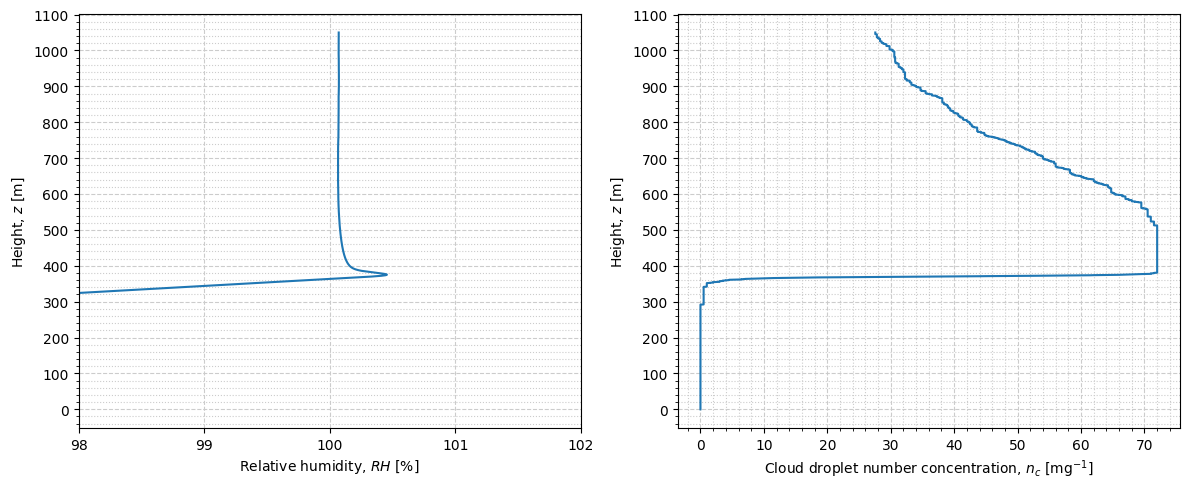

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))


# AX 1

axs[0].plot(test_run['RH_parcel']*100, test_run['z_parcel'])
axs[0].set_xlabel('Relative humidity, $RH$ [%]')

# Major ticks
axs[0].xaxis.set_major_locator(MultipleLocator(1))
axs[0].yaxis.set_major_locator(MultipleLocator(100))

# Minor ticks
axs[0].xaxis.set_minor_locator(AutoMinorLocator(1))
axs[0].yaxis.set_minor_locator(AutoMinorLocator(5))

axs[0].set_xlim(98,102)


# AX 2

axs[1].plot(test_run['nc'], test_run['z_parcel'])
axs[1].set_xlabel('Cloud droplet number concentration, $n_c$ [mg$^{-1}$]')

# Major ticks
axs[1].xaxis.set_major_locator(MultipleLocator(10))
axs[1].yaxis.set_major_locator(MultipleLocator(100))

# Minor ticks
axs[1].xaxis.set_minor_locator(AutoMinorLocator(5))
axs[1].yaxis.set_minor_locator(AutoMinorLocator(5))


for ax in axs:
    ax.set_ylabel('Height, $z$ [m]')
    ax.grid(which='major', color='#CCCCCC', linestyle='--')
    ax.grid(which='minor', color='#CCCCCC', linestyle=':')

plt.tight_layout()
plt.show()

- At what height does the parcel reach its LCL? **(ANS: approx. 360 m)**
- What is the concentration of cloud droplets at a height of 450 m? **(ANS: 72 mg-1)**
- At what height is the cloud base located? **(ANS: 380 m)**
- When does the ascending parcel move through the base of the cloud? **(ANS: ??? same answer as above?)**

### Exercise 1.2

The parcel currently starts at the surface because the corresponding model parameter is set to 'z=0'. Run the model again, this time modifying the parameters such that the parcel starts at 500 m. Also adapt the cloud top height 'z_max' to a value of 1600 m.

- Plot 'relative humidity' and 'cloud droplet number concentration' for the new run.
- Add a plot of the 'mean droplet radius'.

In [7]:
# Reference values
ref_z_init = 500 # m
ref_z_max = 1600 # m
ref_N = 100 # cm-3
ref_w = 0.5 # m s-1

In [8]:
z_widget.value = ref_z_init
max_z_widget.value = ref_z_max

In [9]:
reference_run \
    = create_results_dict(timesteps_function(
        n_particles_widget, P_widget, \
        RH_widget, T_widget, w_widget, nt_widget, \
        dt_widget, rm_spec, ascending_mode_widget, \
        mode_displaytype_widget, z_widget, max_z_widget, \
        Condensation_widget, Collision_widget, \
        mode_aero_init_widget, gridwidget, kohler_widget.value, \
        hygroscopicity_widget.value, switch_sedi_removal.value, \
        entrainment_rate_widget.value,entrainment_widget.value,qv_profiles, theta_profiles, entrainment_start_widget.value, entrainment_end_widget.value
    ))

value: Time (s)  z (m)    T (K)    qv (g/kg) RH (%)   QC (g/kg) QR (g/kg) NA (/mg) NC (/mg) NR (/mg)
after: 3500.0    1550.00  282.29   8.19      100.074   0.878     0.436     20.69     26.31     3.81    


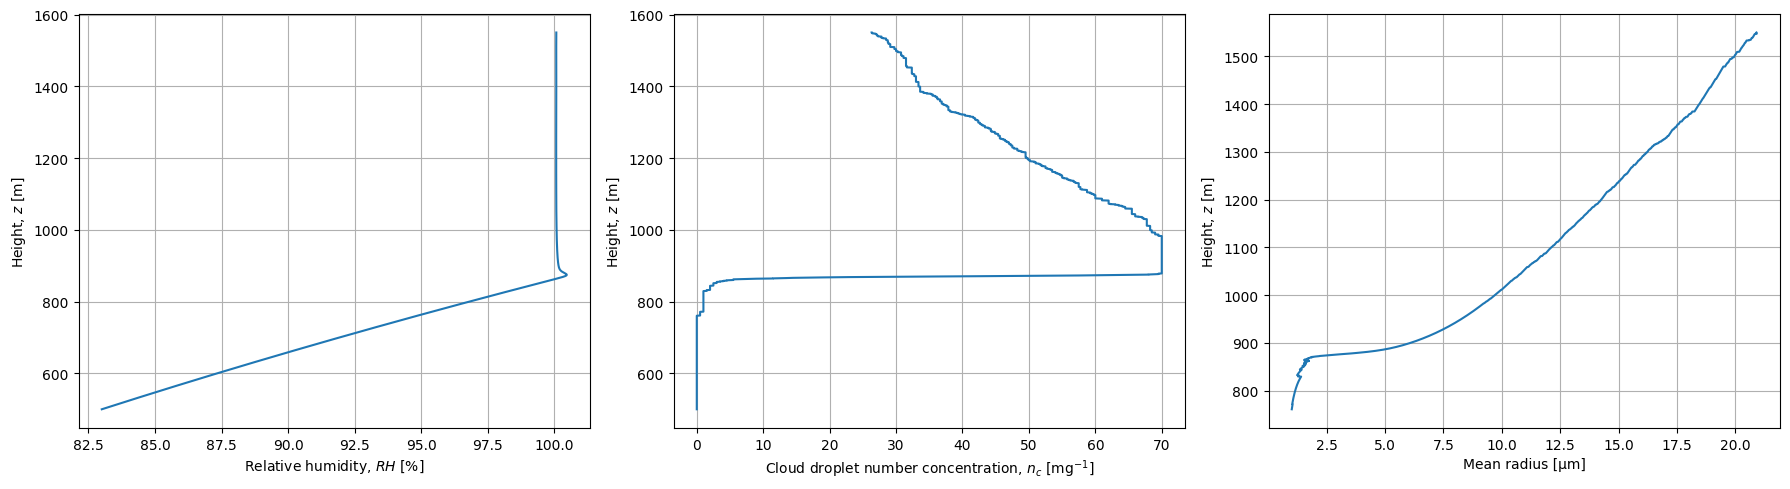

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))


# AX 1

axs[0].plot(reference_run['RH_parcel']*100, reference_run['z_parcel'])
axs[0].set_xlabel('Relative humidity, $RH$ [%]')

# AX 2

axs[1].plot(reference_run['nc'], reference_run['z_parcel'])
axs[1].set_xlabel('Cloud droplet number concentration, $n_c$ [mg$^{-1}$]')

# AX 3

axs[2].plot(reference_run['rc_liq_avg']*1e6, reference_run['z_parcel'])
axs[2].set_xlabel('Mean radius [µm]')

for ax in axs:
    ax.set_ylabel('Height, $z$ [m]')
    ax.grid()

plt.tight_layout()
plt.show()

### Exercise 1.3

The code box below plots a so-called spectrum of cloud droplet sizes. Execute it.

/var/folders/pm/yr9p5vts11g53s85rr_h4kw8tlv16r/T/ipykernel_10832/2174124175.py:3: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contourf(1e6*rm_spec, reference_run['z_parcel'], reference_run['spectra'], norm=matplotlib.colors.LogNorm())


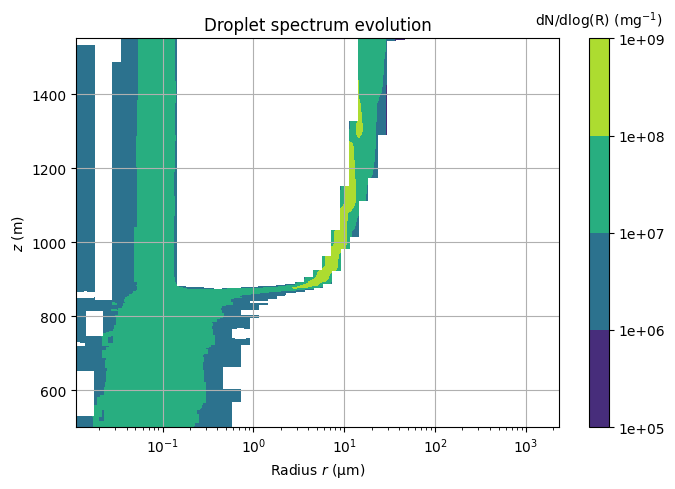

In [43]:
fig, ax = plt.subplots(figsize=(7,5))

contour = ax.contourf(1e6*rm_spec, reference_run['z_parcel'], reference_run['spectra'], norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar(contour, ax=ax, format="%.0e")

ax.set_title('Droplet spectrum evolution')
ax.set_xlabel('Radius $r$ (µm)')
ax.set_ylabel('$z$ (m)')
cbar.ax.set_title('dN/dlog(R) (mg$^{-1}$)', fontsize = 10, pad = 10)
ax.set_xscale('log')
ax.grid()

plt.tight_layout()
plt.show()

### Exercise 1.4

- Compare the plot of the droplet spectrum to the plot of mean radius. What do they have in common, how are they different?
    - **ANS: ...**
- The plot of the droplet number mixing ratio features three different regimes. Explain, which microphysical processes cause these three regimes. Refer to the droplet spectrum to support your explanation.
    - **ANS: ...**

## Exercise 2: What controls the number of droplets in the parcel?

You are now equipped to investigate how the liquid nuber concentration is modified by different factors.

### Exercise 2.1: Influence of pollution

Anthropogenic emissions of fine particulate matter increase the concentration of aerosol particles.

- Study the effect of particulate pollution on the microphysical composition of a cloud by comparing the simulation from Exercise 1.2 to a new, more polluted, simulation, where you double the number concentration of aerosol particles.

- Explain your plots by creating a conceptual diagram that relates aerosol number concentration, cupersaturation, cloud droplet number and mean droplet radius. Which microphysical processes are important? How does your diagram relect the equations of the parcel model?

In [12]:
gridwidget[1,0].value = 2 * ref_N # N_aero (cm-3)

In [13]:
polluted_run \
    = create_results_dict(timesteps_function(
        n_particles_widget, P_widget, \
        RH_widget, T_widget, w_widget, nt_widget, \
        dt_widget, rm_spec, ascending_mode_widget, \
        mode_displaytype_widget, z_widget, max_z_widget, \
        Condensation_widget, Collision_widget, \
        mode_aero_init_widget, gridwidget, kohler_widget.value, \
        hygroscopicity_widget.value, switch_sedi_removal.value, \
        entrainment_rate_widget.value,entrainment_widget.value,qv_profiles, theta_profiles, entrainment_start_widget.value, entrainment_end_widget.value
    ))

value: Time (s)  z (m)    T (K)    qv (g/kg) RH (%)   QC (g/kg) QR (g/kg) NA (/mg) NC (/mg) NR (/mg)
after: 3500.0    1550.00  282.29   8.19      100.051   1.109     0.206     52.50     51.50     2.37    


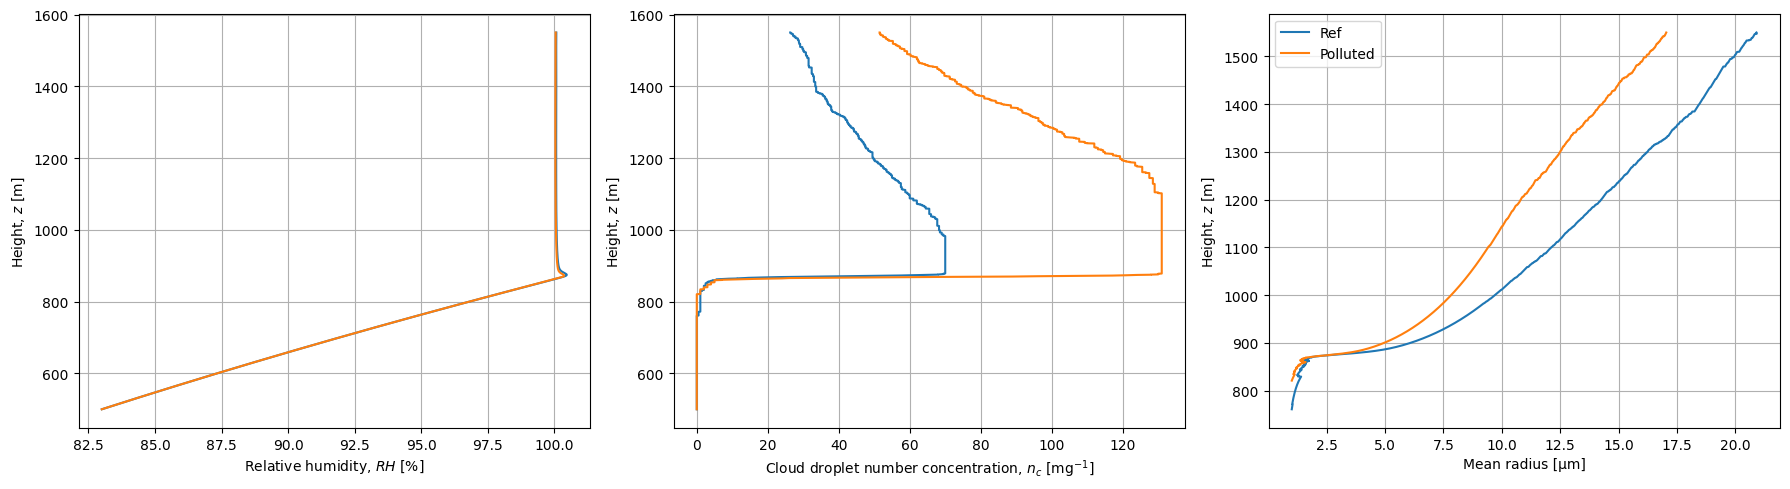

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))


# AX 1

axs[0].plot(reference_run['RH_parcel']*100, reference_run['z_parcel'])
axs[0].plot(polluted_run['RH_parcel']*100, polluted_run['z_parcel'])
axs[0].set_xlabel('Relative humidity, $RH$ [%]')

# AX 2

axs[1].plot(reference_run['nc'], reference_run['z_parcel'])
axs[1].plot(polluted_run['nc'], polluted_run['z_parcel'])
axs[1].set_xlabel('Cloud droplet number concentration, $n_c$ [mg$^{-1}$]')

# AX 3

axs[2].plot(reference_run['rc_liq_avg']*1e6, reference_run['z_parcel'], label="Ref")
axs[2].plot(polluted_run['rc_liq_avg']*1e6, polluted_run['z_parcel'], label="Polluted")
axs[2].set_xlabel('Mean radius [µm]')

for ax in axs:
    ax.set_ylabel('Height, $z$ [m]')
    ax.grid()

plt.legend()

plt.tight_layout()
plt.show()

Solution: N CC up -> N up -> R dow n/ S dow n

### Exercise 2.2: Role of updraft speed

The updraft speed controls how fast the parcel ascends. - Study the effect of different updraft speeds on the microphysical composition of a cloud by comparing the simulation ‘reference_run’ to a simulation ‘fast_run’ w ith a faster parcel ascend, w here you double the updraft speed (parameter ‘w_mean’).- Explain your results by creating a conceptual diagram that relates updraft speed, supersaturation, cloud droplet number and mean droplet radius. Which microphysical processes are important? Hoe does your diagram reflect the equations of the parcel model?

In [15]:
# Reset N to origiinal concentration
gridwidget[1,0].value = ref_N

w_widget.value = 2 * ref_w

In [16]:
fast_run \
    = create_results_dict(timesteps_function(
        n_particles_widget, P_widget, \
        RH_widget, T_widget, w_widget, nt_widget, \
        dt_widget, rm_spec, ascending_mode_widget, \
        mode_displaytype_widget, z_widget, max_z_widget, \
        Condensation_widget, Collision_widget, \
        mode_aero_init_widget, gridwidget, kohler_widget.value, \
        hygroscopicity_widget.value, switch_sedi_removal.value, \
        entrainment_rate_widget.value,entrainment_widget.value,qv_profiles, theta_profiles, entrainment_start_widget.value, entrainment_end_widget.value
    ))

value: Time (s)  z (m)    T (K)    qv (g/kg) RH (%)   QC (g/kg) QR (g/kg) NA (/mg) NC (/mg) NR (/mg)
after: 3500.0    1600.00  282.04   8.09      100.007   1.143     0.267     4.75      41.37     3.12    


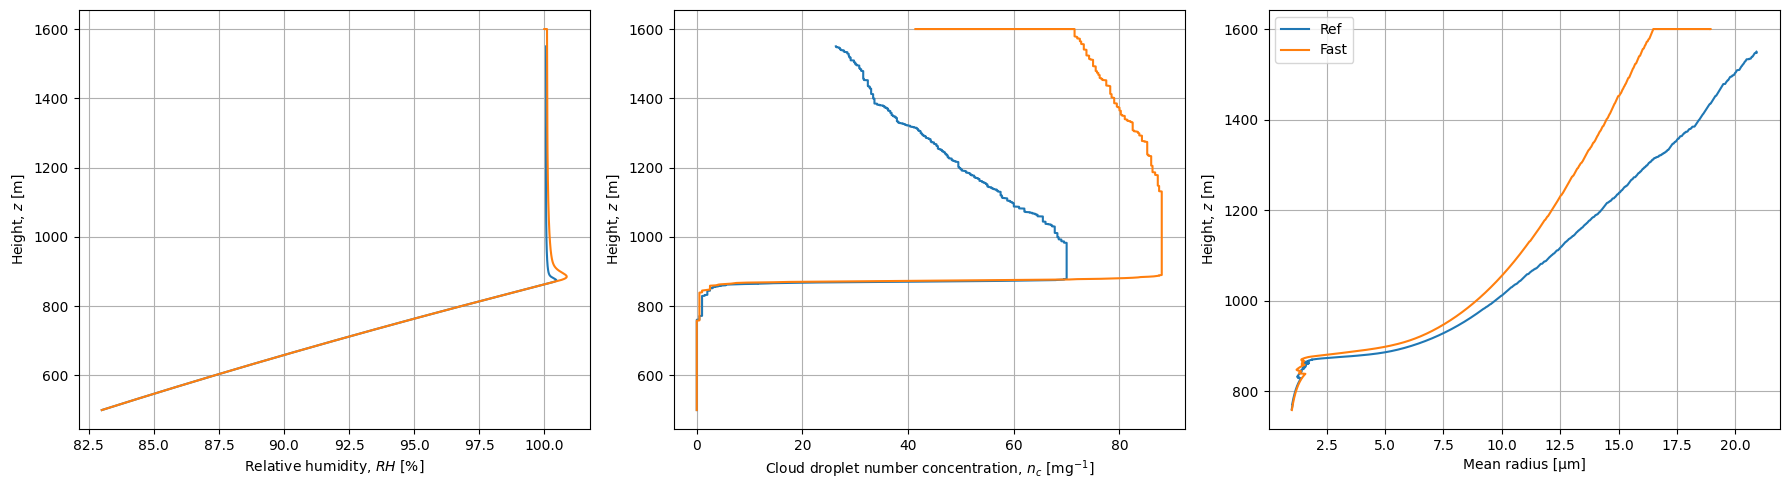

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))


# AX 1

axs[0].plot(reference_run['RH_parcel']*100, reference_run['z_parcel'])
axs[0].plot(fast_run['RH_parcel']*100, fast_run['z_parcel'])
axs[0].set_xlabel('Relative humidity, $RH$ [%]')

# AX 2

axs[1].plot(reference_run['nc'], reference_run['z_parcel'])
axs[1].plot(fast_run['nc'], fast_run['z_parcel'])
axs[1].set_xlabel('Cloud droplet number concentration, $n_c$ [mg$^{-1}$]')

# AX 3

axs[2].plot(reference_run['rc_liq_avg']*1e6, reference_run['z_parcel'], label="Ref")
axs[2].plot(fast_run['rc_liq_avg']*1e6, fast_run['z_parcel'], label="Fast")
axs[2].set_xlabel('Mean radius [µm]')

for ax in axs:
    ax.set_ylabel('Height, $z$ [m]')
    ax.grid()

plt.legend()

plt.tight_layout()
plt.show()

### Exercise 2.3: Importance of cloud thickness

The altitude of the cloud top corresponds to the thickness of the cloud for a given cloud base.

- Study the effect of cloud thickness on the microphysical composition of a cloud by comparing the simulation ‘reference_run’ to a simulation with a lower cloud top ‘thin_run’, where you set the cloud top height to 70% of the reference.

- Explain your results by creating a conceptual diagram that relates cloud top, supersaturation, cloud droplet number and mean droplet radius. Which microphysical processes are important? How does your diagram reflect the equations of the parcel model?

In [18]:
# Reset w to original speed
w_widget.value = ref_w

max_z_widget.value = ref_z_max * 0.7

In [19]:
thin_run \
    = create_results_dict(timesteps_function(
        n_particles_widget, P_widget, \
        RH_widget, T_widget, w_widget, nt_widget, \
        dt_widget, rm_spec, ascending_mode_widget, \
        mode_displaytype_widget, z_widget, max_z_widget, \
        Condensation_widget, Collision_widget, \
        mode_aero_init_widget, gridwidget, kohler_widget.value, \
        hygroscopicity_widget.value, switch_sedi_removal.value, \
        entrainment_rate_widget.value,entrainment_widget.value,qv_profiles, theta_profiles, entrainment_start_widget.value, entrainment_end_widget.value
    ))

value: Time (s)  z (m)    T (K)    qv (g/kg) RH (%)   QC (g/kg) QR (g/kg) NA (/mg) NC (/mg) NR (/mg)
after: 3500.0    1120.00  284.46   9.00      100.011   0.472     0.028     18.87     40.00     0.37    


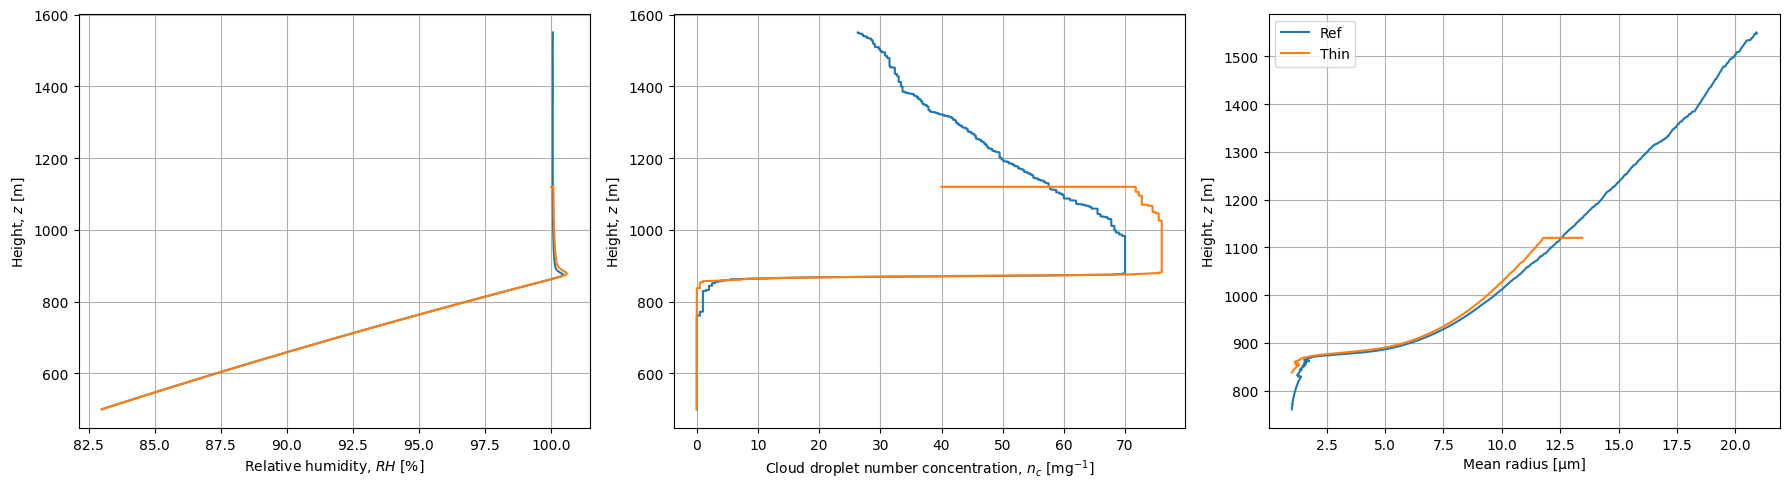

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))


# AX 1

axs[0].plot(reference_run['RH_parcel']*100, reference_run['z_parcel'])
axs[0].plot(thin_run['RH_parcel']*100, thin_run['z_parcel'])
axs[0].set_xlabel('Relative humidity, $RH$ [%]')

# AX 2

axs[1].plot(reference_run['nc'], reference_run['z_parcel'])
axs[1].plot(thin_run['nc'], thin_run['z_parcel'])
axs[1].set_xlabel('Cloud droplet number concentration, $n_c$ [mg$^{-1}$]')

# AX 3

axs[2].plot(reference_run['rc_liq_avg']*1e6, reference_run['z_parcel'], label="Ref")
axs[2].plot(thin_run['rc_liq_avg']*1e6, thin_run['z_parcel'], label="Thin")
axs[2].set_xlabel('Mean radius [µm]')

for ax in axs:
    ax.set_ylabel('Height, $z$ [m]')
    ax.grid()

plt.legend()

plt.tight_layout()
plt.show()

### Exercise 2.4: Aerosol vs. meteorology

Based on your experiments, comment on the following statement:

" The aerosol conditions are more important than meteorological factors like updraft and cloud thickness in controlling the droplet number concentration. "

Solution: N A * 2 -> 1.5 * N
w * 2 -> 2 * N
D * 2 -> N / 4
=> meteo factors are relatively more important

## Exercise 3: Cloud albedo and precipitation

The microphysical composition of a cloud as described by the profiles/ timeseries of liquid number concentration and droplet radii determine the cloud albedo and the amount of rain formed in the cloud. The follow ing code box gives you an example of how to calculate albedo and rain for a given simulation.

- Describe how aerosol, updraft and cloud thickness influence albedo and rain.

- Can you explain your observations, when taking into account that:

    - The amount of rain corresponds to the total mass of all big droplets in a cloud.
    - Cloud albedo depends on the total durface of all the droplets in a cloud.

- Add albedo and rain to your conceptual diagrams from Exercise 2.

In [21]:
print(f"""
ALBEDO:

Reference run:\t{reference_run['albedo'][-1]:.3}
Polluted run:\t{polluted_run['albedo'][-1]:.3}
Fast run:\t{fast_run['albedo'][-1]:.3}
Thin run:\t{thin_run['albedo'][-1]:.3}

RWP (kg m-2):

Reference run:\t{rwp(reference_run, 0.5)[-1]*1e-3:.3}
Polluted run:\t{rwp(polluted_run, 0.5)[-1]*1e-3:.3}
Fast run:\t{rwp(fast_run, 1.0)[-1]*1e-3:.3}
Thin run:\t{rwp(thin_run, 0.5)[-1]*1e-3:.3}
""")


ALBEDO:

Reference run:	0.861
Polluted run:	0.888
Fast run:	0.979
Thin run:	0.916

RWP (kg m-2):

Reference run:	0.0949
Polluted run:	0.0218
Fast run:	0.557
Thin run:	0.00515



Solution:

- Albedo: N up, w up, D up -> albedo up
    - Explanation:
        - N up: increased surface for fixed total water
        - w up: N up, D up: more water
- Rain: N up, w up, D down -> rain down
    - Explanation:
        - N up: R down
        - W up: N up, D down: R down

Conceptual diagrams:

N up -> A up R up -> rain up